In [ ]:
# Install dependencies
!pip install transformers datasets accelerate -q

import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from google.colab import drive

drive.mount('/content/drive')

# Make sure ETSP directory is on the path for module imports
etsp_utils_path = '/content/drive/MyDrive/Colab Notebooks/ETSP/utils'
sys.path.append(etsp_utils_path)

print(f"Listing contents of {etsp_utils_path}:")
!ls "{etsp_utils_path}"

from prepare_dataset import make_datasets
os.environ["WANDB_DISABLED"] = "true"

# Set file path and dialects
file_path = '/content/drive/MyDrive/Colab Notebooks/ETSP/sentences_ch_de_transcribed.json'
dialects = ['ch_sg', 'ch_be', 'ch_gr', 'ch_zh', 'ch_vs', 'ch_bs', 'ch_ag', 'ch_lu']

# Load datasets and label mappings
train_dataset, val_dataset, test_dataset, dialect2label, _, _, _ = make_datasets(file_path, dialects)
label2dialect = {i: d for d, i in dialect2label.items()}

Mounted at /content/drive
Listing contents of /content/drive/MyDrive/Colab Notebooks/ETSP/utils:
data_loader.py	__init__.py  prepare_dataset.py  __pycache__


In [ ]:
model_name = "xlm-roberta-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(dialects)
)

def tokenize_fn(example):
    return tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

train_dataset = train_dataset.map(tokenize_fn, batched=True)
val_dataset   = val_dataset.map(tokenize_fn, batched=True)
test_dataset  = test_dataset.map(tokenize_fn, batched=True)


for ds in [train_dataset, val_dataset, test_dataset]:
    ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/16184 [00:00<?, ? examples/s]

Map:   0%|          | 0/2024 [00:00<?, ? examples/s]

Map:   0%|          | 0/2024 [00:00<?, ? examples/s]

In [ ]:
from transformers import EvalPrediction

def compute_metrics(eval_pred: EvalPrediction):
    # eval_pred is an EvalPrediction with .predictions and .label_ids
    logits = eval_pred.predictions
    labels = eval_pred.label_ids

    # For sequence classification, logits shape: (batch_size, num_labels)
    predictions = np.argmax(logits, axis=-1)

    accuracy = (predictions == labels).mean()

    # label2dialect: {0: 'ch_sg', 1: 'ch_be', ...}
    target_names = [label2dialect[i] for i in range(len(label2dialect))]

    report = classification_report(
        labels,
        predictions,
        target_names=target_names,
        output_dict=True,
        zero_division=0,
    )

    metrics = {
        "accuracy": accuracy,
        "macro_f1": report["macro avg"]["f1-score"],
    }

    for i, dialect in label2dialect.items():
        metrics[f"f1_{dialect}"] = report[dialect]["f1-score"]
        metrics[f"precision_{dialect}"] = report[dialect]["precision"]
        metrics[f"recall_{dialect}"] = report[dialect]["recall"]

    return metrics

In [ ]:
from transformers import TrainingArguments, Trainer

# Training arguments (XLM-R)
training_args = TrainingArguments(
    output_dir="./xlmr-swissdial-results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    num_train_epochs=3,
    logging_dir="./xlmr-logs",
    save_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
)

# Initialize Trainer and Train
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,         # XLM-R tokenizer
    compute_metrics=compute_metrics,
)

trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-704465608.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,F1 Ch Sg,Precision Ch Sg,Recall Ch Sg,F1 Ch Be,Precision Ch Be,Recall Ch Be,F1 Ch Gr,Precision Ch Gr,Recall Ch Gr,F1 Ch Zh,Precision Ch Zh,Recall Ch Zh,F1 Ch Vs,Precision Ch Vs,Recall Ch Vs,F1 Ch Bs,Precision Ch Bs,Recall Ch Bs,F1 Ch Ag,Precision Ch Ag,Recall Ch Ag,F1 Ch Lu,Precision Ch Lu,Recall Ch Lu
1,0.864300,0.631127,0.761858,0.765245,0.666667,0.580645,0.782609,0.841163,0.969072,0.743083,0.892430,0.899598,0.885375,0.627306,0.588235,0.671937,0.899010,0.900794,0.897233,0.682403,0.746479,0.628458,0.778195,0.741935,0.818182,0.734783,0.816425,0.667984
2,0.496400,0.440007,0.826087,0.828254,0.723735,0.712644,0.735178,0.913223,0.956710,0.873518,0.926531,0.957806,0.897233,0.686567,0.650177,0.727273,0.950690,0.948819,0.952569,0.775194,0.760456,0.790514,0.839604,0.841270,0.837945,0.810484,0.827160,0.794466
3,0.399300,0.404828,0.837945,0.838176,0.744275,0.719557,0.770751,0.920892,0.945833,0.897233,0.933333,0.954545,0.913043,0.712215,0.747826,0.679842,0.952569,0.952569,0.952569,0.800000,0.758865,0.845850,0.837037,0.787456,0.893281,0.805085,0.867580,0.750988


TrainOutput(global_step=3036, training_loss=0.7328547259721517, metrics={'train_runtime': 1298.4113, 'train_samples_per_second': 37.393, 'train_steps_per_second': 2.338, 'total_flos': 3193814036496384.0, 'train_loss': 0.7328547259721517, 'epoch': 3.0})

Test set metrics: {'eval_loss': 0.3925371766090393, 'eval_accuracy': 0.8404150197628458, 'eval_macro_f1': 0.8409385622862564, 'eval_f1_ch_sg': 0.7877697841726619, 'eval_precision_ch_sg': 0.7227722772277227, 'eval_recall_ch_sg': 0.8656126482213439, 'eval_f1_ch_be': 0.8991935483870968, 'eval_precision_ch_be': 0.9176954732510288, 'eval_recall_ch_be': 0.8814229249011858, 'eval_f1_ch_gr': 0.9352226720647774, 'eval_precision_ch_gr': 0.9585062240663901, 'eval_recall_ch_gr': 0.9130434782608695, 'eval_f1_ch_zh': 0.7325102880658436, 'eval_precision_ch_zh': 0.7639484978540773, 'eval_recall_ch_zh': 0.7035573122529645, 'eval_f1_ch_vs': 0.9425742574257425, 'eval_precision_ch_vs': 0.9444444444444444, 'eval_recall_ch_vs': 0.9407114624505929, 'eval_f1_ch_bs': 0.7470817120622568, 'eval_precision_ch_bs': 0.735632183908046, 'eval_recall_ch_bs': 0.758893280632411, 'eval_f1_ch_ag': 0.8566037735849057, 'eval_precision_ch_ag': 0.8194945848375451, 'eval_recall_ch_ag': 0.8972332015810277, 'eval_f1_ch_lu': 0.826

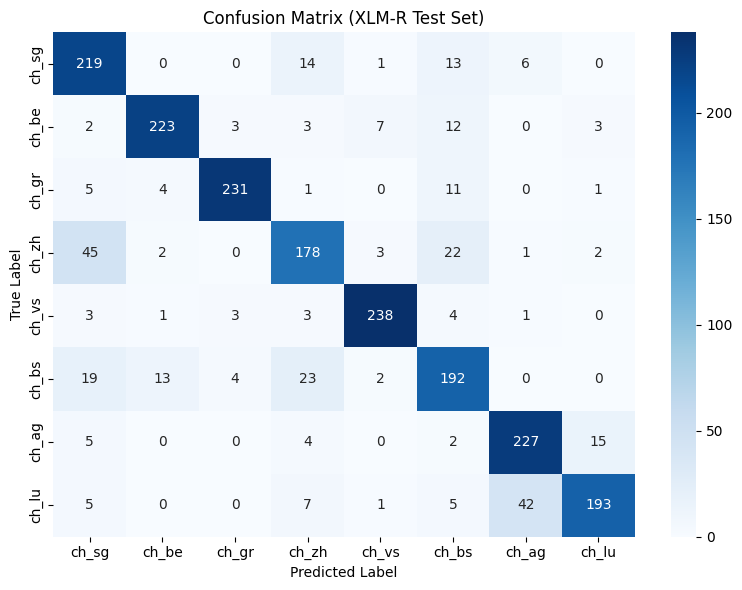

In [ ]:
# --- Evaluate XLM-R on the test set ---
results = trainer.evaluate(test_dataset)
print("Test set metrics:", results)
print("Label mapping:", label2dialect)

# --- Predict on test set ---
outputs = trainer.predict(test_dataset)
y_true = outputs.label_ids
y_pred = np.argmax(outputs.predictions, axis=-1)

print(classification_report(
    y_true,
    y_pred,
    target_names=[label2dialect[i] for i in range(len(label2dialect))]
))

# --- Confusion matrix ---
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[label2dialect[i] for i in range(len(label2dialect))],
    yticklabels=[label2dialect[i] for i in range(len(label2dialect))]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (XLM-R Test Set)")
plt.tight_layout()
plt.show()